# Imports

In [4]:
# Data processing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning libraries

import keras
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image

# Analysis libraries

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Utils libraries

import kagglehub
import time
import random
import datetime

# Google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data management

Found 26179 files belonging to 10 classes.
Using 24871 files for training.
Found 26179 files belonging to 10 classes.
Using 1308 files for validation.
Training classes => ['dog' 'horse' 'elephant' 'butterfly' 'chicken' 'cat' 'cow' 'sheep'
 'spider' 'squirrel']
Shape of the training set images => (42, 180, 180, 3)
Shape of the training set labels => (42,)
Shape of the testing set images => (42, 180, 180, 3)
Shape of the testing set labels => (42,)


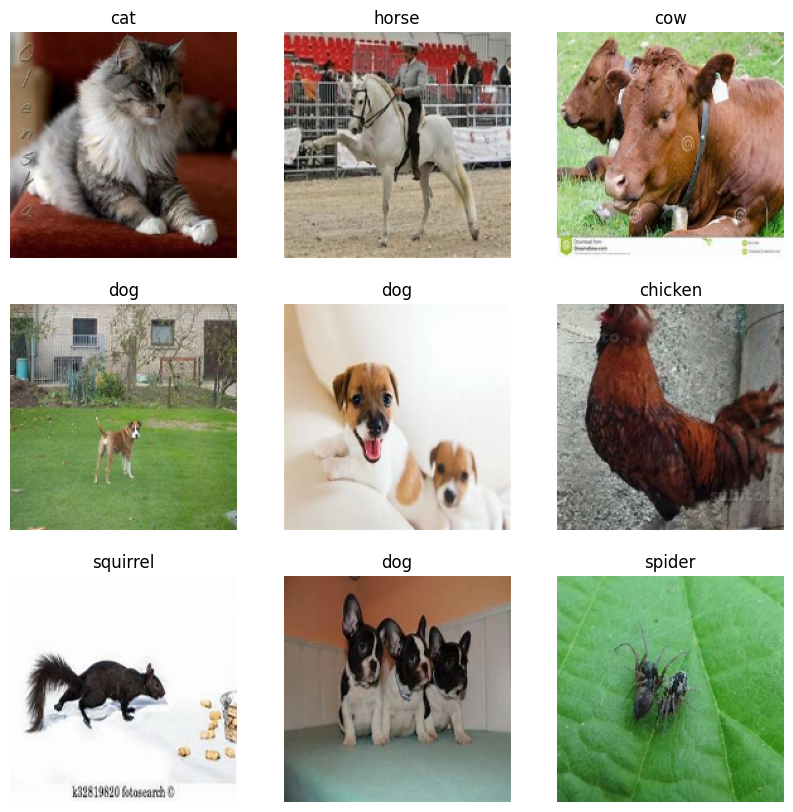

In [20]:
# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")
DATASET_URI= path + "/raw-img"

# Determine the unique seed for our data

random.seed(42)
seed = random.randint(1, 200)

# Determine the image and batch sizes

batch_size = 42

img_height = 180
img_width = 180
image_size = (img_height, img_width)

# Determine the validation split (ie. 90% train, 10% test for ex.)
validation_split = 0.05 # Split of 5%

train_ds = keras.utils.image_dataset_from_directory(
    directory=DATASET_URI,
    validation_split=validation_split,
    subset="training",  # Use 'training' subset
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = keras.utils.image_dataset_from_directory(
  directory = DATASET_URI,
  validation_split = validation_split,
  subset = "validation",
  seed = seed,
  image_size = image_size,
  batch_size = batch_size,
)

italian_to_english = {
    'cane': 'dog',
    'cavallo': 'horse',
    'elefante': 'elephant',
    'farfalla': 'butterfly',
    'gallina': 'chicken',
    'gatto': 'cat',
    'mucca': 'cow',
    'pecora': 'sheep',
    'ragno': 'spider',
    'scoiattolo': 'squirrel'
}

# We print the class names for double check.
class_names = np.array([italian_to_english[name] for name in test_ds.class_names])
nb_classes = len(class_names)
print(f"Training classes => {class_names}")


# Print the shapes of the training and the testing dataset
for image_batch, labels_batch in train_ds:
    print(f"Shape of the training set images => {image_batch.shape}")
    print(f"Shape of the training set labels => {labels_batch.shape}")
    break

for image_batch, labels_batch in test_ds:
    print(f"Shape of the testing set images => {image_batch.shape}")
    print(f"Shape of the testing set labels => {labels_batch.shape}")
    break

# Print a summary of the image classes with an image of each class.
# We will extract 1 image of the training set.

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names) - 1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Auto-tuning our data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalizing the data
# normalization_layer = keras.layers.Rescaling(1./255)
# test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Final model JJ

Inspired by Mo's model

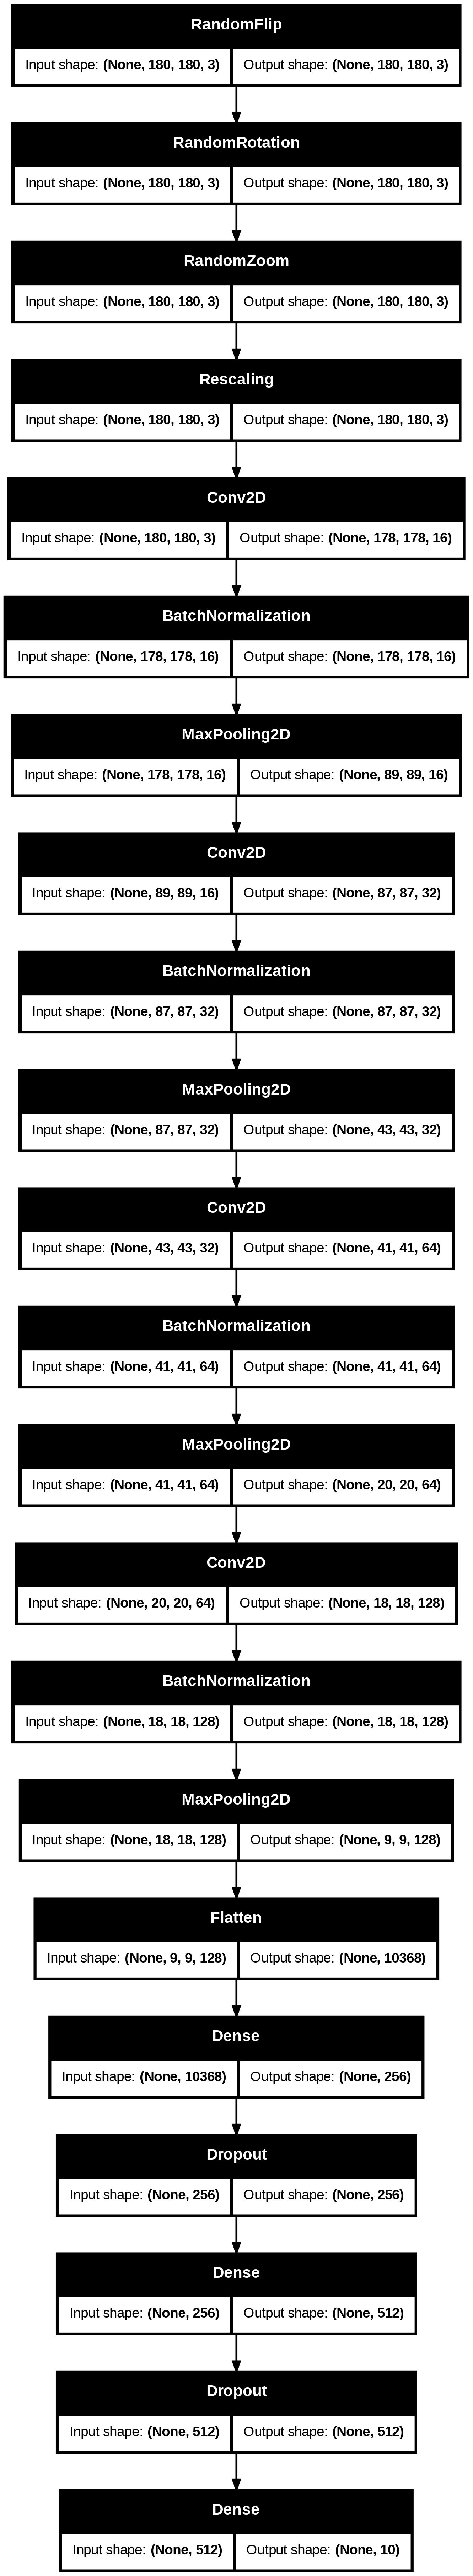

In [26]:
# Model creation
final_model = keras.models.Sequential([
    # defines input shape
    keras.layers.Input(shape = (180,180, 3)),

    keras.layers.RandomFlip("horizontal_and_vertical"), # Add random flip and rotation
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.4),

    # homogeneus range
    keras.layers.Rescaling(1./255),

    keras.layers.Conv2D(16, (3, 3), activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(32, (3, 3), activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(64, (3, 3), activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Conv2D(128, (3, 3), activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(2, 2),

    keras.layers.Flatten(),

    keras.layers.Dense(256, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.21), # Lowering to 0.21 dropout

    keras.layers.Dense(512, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.42), # Lowering to 0.42 dropout

    keras.layers.Dense(nb_classes, activation = "softmax")
])

keras.utils.plot_model(final_model, show_shapes=True)

Model summary

In [27]:
final_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_5 (RandomFlip)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_5               │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_5 (RandomZoom)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 178, 178, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 87, 87, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 41, 41, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,889,578 (11.02 MB)

 Trainable params: 2,889,098 (11.02 MB)

 Non-trainable params: 480 (1.88 KB)

Training

In [28]:
# Define the number of epochs
epochs = 50

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CNN_Image_classification/final_model_JJ_at_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',  # Monitor validation accuracy
        factor=0.5,
        patience=3,
        min_lr=0.0001,
        cooldown=3,
        mode='max',  # Since accuracy is being monitored
    )
]

# Compile the model
final_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Get true labels for class weights calculation
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(true_labels), y=true_labels)
class_weights = dict(enumerate(class_weights))

# Train the model
history_3 = final_model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=test_ds,
    batch_size=batch_size,
    class_weight=class_weights
)

Epoch 1/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 28s 40ms/step - accuracy: 0.1557 - loss: 3.4782 - val_accuracy: 0.2561 - val_loss: 2.6767 - learning_rate: 0.0010
Epoch 2/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.1962 - loss: 2.7219 - val_accuracy: 0.2018 - val_loss: 2.5967 - learning_rate: 0.0010
Epoch 3/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.2250 - loss: 2.4927 - val_accuracy: 0.2706 - val_loss: 2.2906 - learning_rate: 0.0010
Epoch 4/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.2774 - loss: 2.3465 - val_accuracy: 0.3226 - val_loss: 2.2315 - learning_rate: 0.0010
Epoch 5/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.3328 - loss: 2.2427 - val_accuracy: 0.3310 - val_loss: 2.2509 - learning_rate: 0.0010
Epoch 6/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.3794 - loss: 2.2074 - val_accuracy: 0.3203 - val_loss: 2.3103 - learning_rate: 0.0010
Epoch 7/50
593/593 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.4249 - l

Retrieve the keys

In [29]:
print(history_3.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


Print the history graph

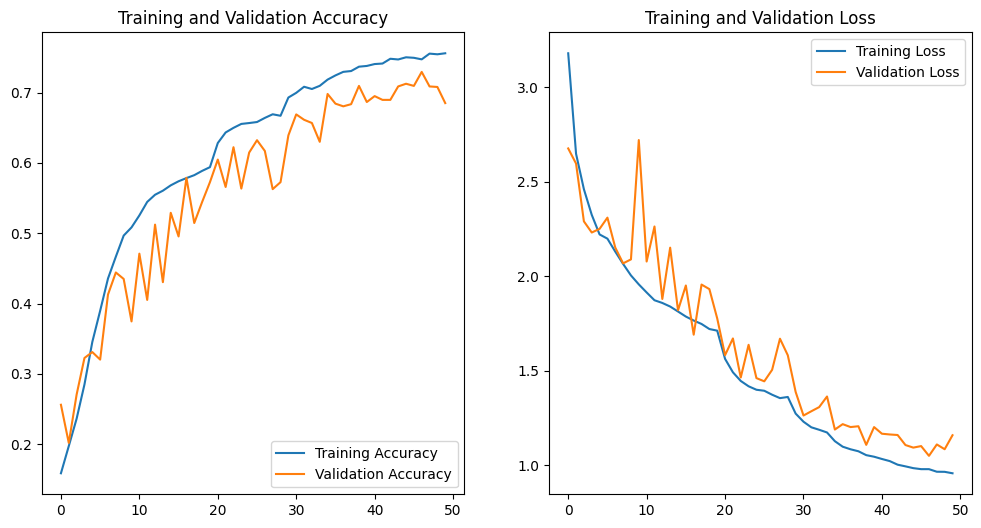

In [30]:
# Visualize the learning curves
def plot_learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Plot the learning curves
plot_learning_curves(history_3)

Model evaluation

In [31]:
test_loss, test_acc = final_model.evaluate(test_ds, verbose=1)
print('Test loss => ', test_loss)
print('Test accuracy => ', test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7162 - loss: 1.0934
Test loss =>  1.0491195917129517
Test accuracy =>  0.7293577790260315


Predictions

In [32]:
# Predict
predicted_batch = final_model.predict(test_ds)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


Visualize predictions

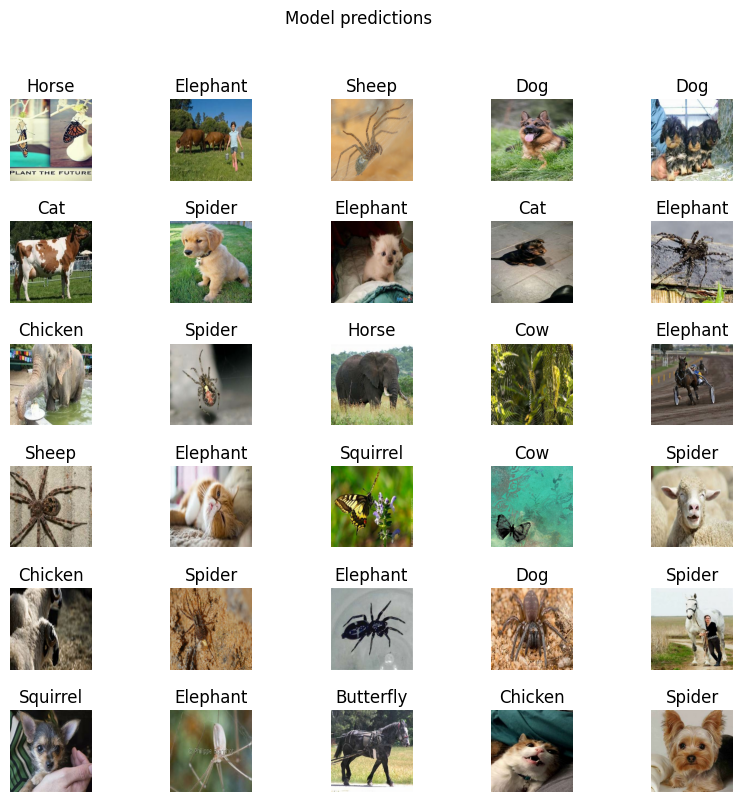

In [33]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  clipped_image = np.clip(image_batch[n], 0, 255).astype(np.uint8)
  plt.imshow(clipped_image)
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

Confusion matrix

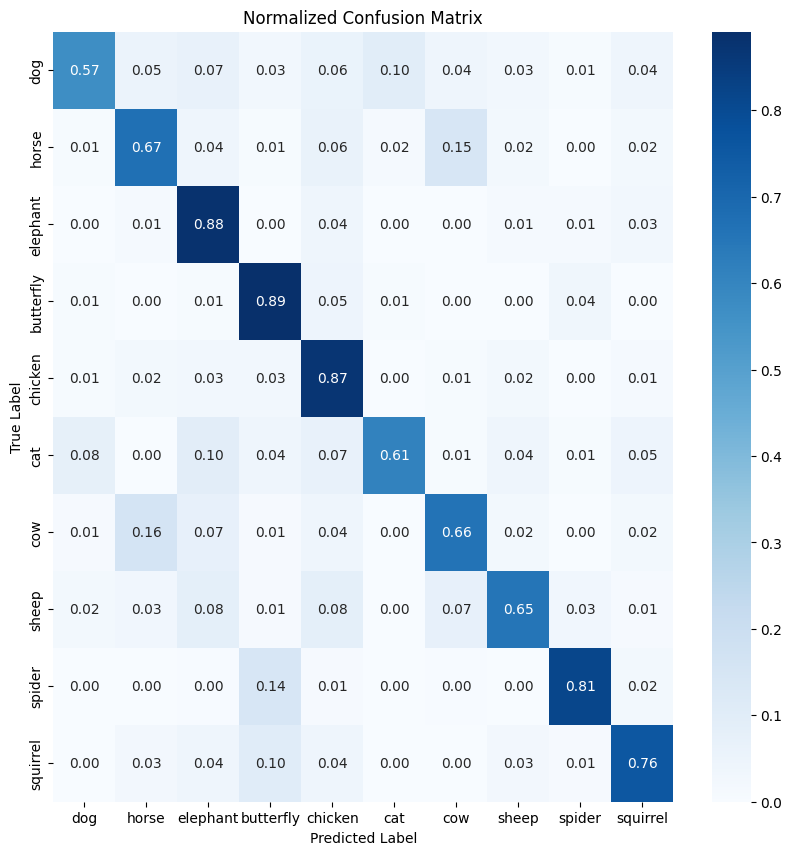

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_id)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Display normalized confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.show()

Generate classification report

In [35]:
report = classification_report(true_labels, predicted_id, target_names=class_names)
print(report)

              precision    recall  f1-score   support

         dog       0.91      0.57      0.70       239
       horse       0.69      0.67      0.68       124
    elephant       0.52      0.88      0.65        67
   butterfly       0.61      0.89      0.72       110
     chicken       0.69      0.87      0.77       139
         cat       0.70      0.61      0.65       103
         cow       0.62      0.66      0.64        94
       sheep       0.74      0.65      0.69        95
      spider       0.95      0.81      0.88       259
    squirrel       0.66      0.76      0.70        78

    accuracy                           0.73      1308
   macro avg       0.71      0.74      0.71      1308
weighted avg       0.76      0.73      0.73      1308



In [36]:
final_model.save("/content/drive/MyDrive/AI Engineering/Projects/CNN - Image Classification/final_model_JJ.keras")